# Exploratory Data Analysis (EDA) - Diabetes Dataset
## Comprehensive analysis to understand data distribution, missing values, correlations, and class differences

## 1. Import Libraries and Load Data

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Configure visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Load the dataset from parquet file
df = pd.read_parquet('../data/final/nhanes_diabetes.parquet')

print("Dataset loaded successfully")
print(f"Shape: {df.shape}")

Dataset loaded successfully
Shape: (57395, 31)


## 2. General Dataset Information

In [51]:
# Display general information about the dataset
print("=" * 80)
print("GENERAL DATASET INFORMATION")
print("=" * 80)

# Dimensions and basic info
print(f"\nDimensions: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"\nData types:\n{df.dtypes}")
print(f"\nMemory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Display first rows
print("\nFirst 5 rows:")
display(df.head())

# Display last rows
print("\nLast 5 rows:")
display(df.tail())

GENERAL DATASET INFORMATION

Dimensions: 57395 rows × 31 columns

Data types:
id                         float64
alcohol_ever               float64
avg_drinks_day             float64
creatinine_mgdl            float64
height_cm                  float64
bmi                        float64
waist_cm                   float64
sbp_1                      float64
dbp_1                      float64
sbp_2                      float64
dbp_2                      float64
gender                     float64
age_years                  float64
ethnicity                  float64
pregnancies_n              float64
poverty_ratio              float64
diabetes_dx                float64
family_history_diabetes    float64
protein_g                  float64
carbs_g                    float64
fat_g                      float64
hba1c_percent              float64
glucose_mgdl               float64
insulin_uUml               float64
hdl_mgdl                   float64
sedentary_min_week         float64
smoking_stat

,id,alcohol_ever,avg_drinks_day,creatinine_mgdl,height_cm,bmi,waist_cm,sbp_1,dbp_1,sbp_2,...,hba1c_percent,glucose_mgdl,insulin_uUml,hdl_mgdl,sedentary_min_week,smoking_status,chol_total_mgdl,triglycerides_mgdl,ldl_mgdl,cycle
0,62161.0,2.0,NaN,0.91,172.3,23.3,81.0,110.0,82.0,104.0,...,5.1,92.0,18.65,41.0,2.0,2.0,168.0,84.0,110.0,2011-2012
1,62162.0,NaN,NaN,NaN,94.7,14.2,45.4,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-2012
2,62163.0,NaN,NaN,0.65,168.9,17.3,64.6,112.0,38.0,108.0,...,5.5,NaN,NaN,44.0,2.0,NaN,154.0,NaN,NaN,2011-2012
3,62164.0,NaN,NaN,0.89,170.1,23.2,80.1,116.0,56.0,118.0,...,4.9,82.0,3.51,28.0,1.0,2.0,190.0,56.0,151.0,2011-2012
4,62165.0,NaN,NaN,0.50,159.4,27.2,86.7,110.0,64.0,104.0,...,5.9,88.0,15.35,63.0,2.0,NaN,161.0,71.0,84.0,2011-2012



Last 5 rows:


,id,alcohol_ever,avg_drinks_day,creatinine_mgdl,height_cm,bmi,waist_cm,sbp_1,dbp_1,sbp_2,...,hba1c_percent,glucose_mgdl,insulin_uUml,hdl_mgdl,sedentary_min_week,smoking_status,chol_total_mgdl,triglycerides_mgdl,ldl_mgdl,cycle
57390,142306.0,NaN,NaN,NaN,128.0,15.4,57.7,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-2022
57391,142307.0,NaN,1.0,0.79,143.8,NaN,NaN,NaN,NaN,NaN,...,6.2,NaN,NaN,79.0,NaN,1.0,205.0,NaN,NaN,2021-2022
57392,142308.0,NaN,2.0,NaN,173.3,26.4,98.4,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,2021-2022
57393,142309.0,NaN,NaN,1.05,179.1,25.5,96.0,NaN,NaN,NaN,...,5.2,96.0,6.22,54.0,NaN,2.0,255.0,NaN,180.0,2021-2022
57394,142310.0,NaN,3.0,1.01,161.7,27.6,110.8,NaN,NaN,NaN,...,5.3,NaN,NaN,48.0,NaN,1.0,167.0,NaN,NaN,2021-2022


## 3. Missing Data Analysis

MISSING DATA ANALYSIS

Missing values per column:


,Column,Missing_Count,Missing_Percentage
14,pregnancies_n,50213,87.486715
28,triglycerides_mgdl,43886,76.463107
1,alcohol_ever,41789,72.809478
29,ldl_mgdl,40552,70.654238
23,insulin_uUml,40365,70.328426
22,glucose_mgdl,39802,69.347504
2,avg_drinks_day,37154,64.733862
7,sbp_1,36322,63.284258
8,dbp_1,36322,63.284258
9,sbp_2,35765,62.313790


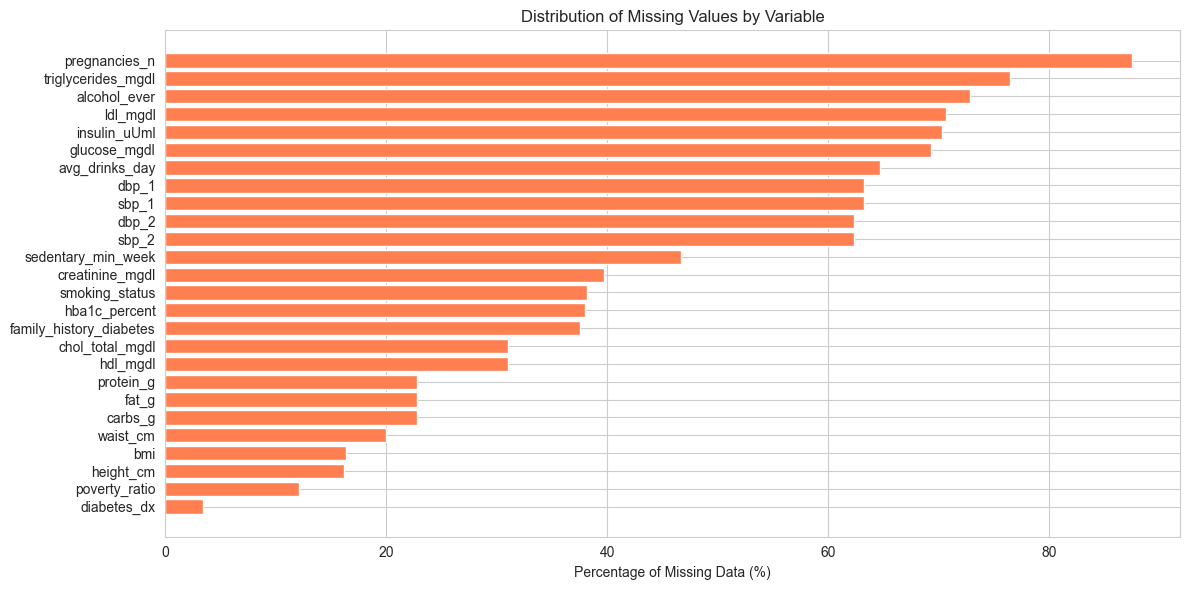

In [52]:
# Analyze missing values across all features
print("=" * 80)
print("MISSING DATA ANALYSIS")
print("=" * 80)

# Count missing values per column
missing_data = df.isnull().sum()
missing_percent = (df.isnull().sum() / len(df)) * 100
missing_df = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': missing_data.values,
    'Missing_Percentage': missing_percent.values
}).sort_values('Missing_Count', ascending=False)

print("\nMissing values per column:")
display(missing_df[missing_df['Missing_Count'] > 0])

# Visualize missing data if any exists
if missing_data.sum() > 0:
    plt.figure(figsize=(12, 6))
    missing_df_sorted = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=True)
    plt.barh(missing_df_sorted['Column'], missing_df_sorted['Missing_Percentage'], color='coral')
    plt.xlabel('Percentage of Missing Data (%)')
    plt.title('Distribution of Missing Values by Variable')
    plt.tight_layout()
    plt.show()
else:
    print("\n No missing data found in the dataset")

## 4. Target Variable Analysis (Diabetes)

TARGET VARIABLE ANALYSIS: DIABETES

Unique values in 'diabetes_dx':
diabetes_dx
1.0     4827
2.0    49553
3.0     1025
7.0        2
9.0       26
Name: count, dtype: int64

Distribution (%):
diabetes_dx
1.0     8.707809
2.0    89.392600
3.0     1.849079
7.0     0.003608
9.0     0.046903
Name: proportion, dtype: float64

Total records before filtering: 57395
Records after filtering only diabetes (1, 2): 54380
Records removed: 3015

Class distribution after filtering:
diabetes_dx
1.0     4827
2.0    49553
Name: count, dtype: int64


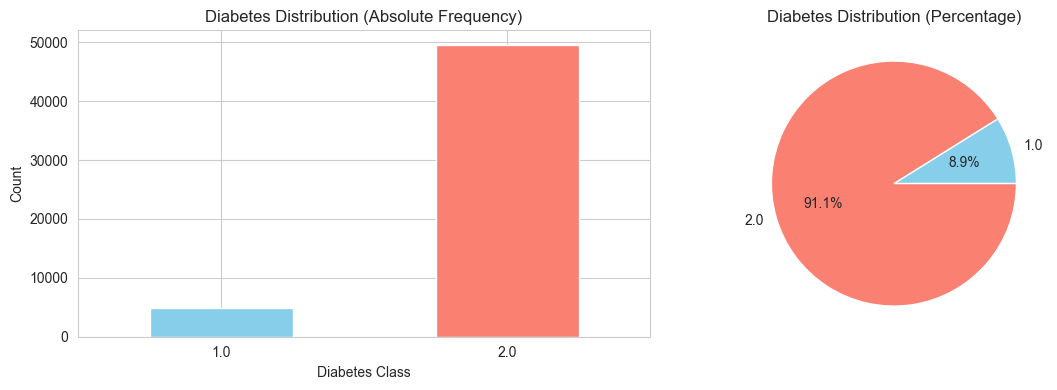


Imbalance ratio: 10.27:1


In [53]:
# Analyze the diabetes target variable
print("=" * 80)
print("TARGET VARIABLE ANALYSIS: DIABETES")
print("=" * 80)

# Define target column name - ADJUST IF YOUR COLUMN NAME IS DIFFERENT
target_col = 'diabetes_dx'  # CHANGE THIS IF NEEDED

# Examine unique values
print(f"\nUnique values in '{target_col}':")
print(df[target_col].value_counts().sort_index())

print(f"\nDistribution (%):")
print((df[target_col].value_counts(normalize=True) * 100).sort_index())

# Filter to keep only positive (1) and negative (2) cases
print(f"\nTotal records before filtering: {len(df)}")
df_filtered = df[df[target_col].isin([1, 2])].copy()
print(f"Records after filtering only diabetes (1, 2): {len(df_filtered)}")
print(f"Records removed: {len(df) - len(df_filtered)}")

# Update dataframe with filtered data
df = df_filtered

# Display class distribution after filtering
print(f"\nClass distribution after filtering:")
class_dist = df[target_col].value_counts().sort_index()
print(class_dist)

# Visualize target distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Bar chart - absolute frequency
class_dist.plot(kind='bar', ax=axes[0], color=['skyblue', 'salmon'])
axes[0].set_title('Diabetes Distribution (Absolute Frequency)')
axes[0].set_xlabel('Diabetes Class')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# Pie chart - percentage
class_dist.plot(kind='pie', ax=axes[1], autopct='%1.1f%%', colors=['skyblue', 'salmon'])
axes[1].set_title('Diabetes Distribution (Percentage)')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

# Calculate and display class imbalance ratio
imbalance_ratio = class_dist.max() / class_dist.min()
print(f"\nImbalance ratio: {imbalance_ratio:.2f}:1")

## 5. Descriptive Statistics for Numeric Variables

In [54]:
# Compute descriptive statistics for all numeric features
print("=" * 80)
print("DESCRIPTIVE STATISTICS - NUMERIC VARIABLES")
print("=" * 80)

# Select numeric columns (excluding target variable)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if target_col in numeric_cols:
    numeric_cols.remove(target_col)

print(f"\nNumeric variables found: {len(numeric_cols)}")
print(f"Columns: {numeric_cols}\n")

# Calculate comprehensive descriptive statistics
desc_stats = df[numeric_cols].describe().T
desc_stats['variance'] = df[numeric_cols].var()
desc_stats['skewness'] = df[numeric_cols].skew()
desc_stats['kurtosis'] = df[numeric_cols].kurtosis()

print("\nComprehensive descriptive statistics:")
display(desc_stats)

DESCRIPTIVE STATISTICS - NUMERIC VARIABLES

Numeric variables found: 29
Columns: ['id', 'alcohol_ever', 'avg_drinks_day', 'creatinine_mgdl', 'height_cm', 'bmi', 'waist_cm', 'sbp_1', 'dbp_1', 'sbp_2', 'dbp_2', 'gender', 'age_years', 'ethnicity', 'pregnancies_n', 'poverty_ratio', 'family_history_diabetes', 'protein_g', 'carbs_g', 'fat_g', 'hba1c_percent', 'glucose_mgdl', 'insulin_uUml', 'hdl_mgdl', 'sedentary_min_week', 'smoking_status', 'chol_total_mgdl', 'triglycerides_mgdl', 'ldl_mgdl']


Comprehensive descriptive statistics:


,count,mean,std,min,25%,50%,75%,max,variance,skewness,kurtosis
id,54380.0,100948.917304,25591.784249,62161.00,78197.75,92601.500,122557.2500,142310.00,6.549394e+08,0.108041,-1.452931
alcohol_ever,15211.0,1.310828,0.515532,1.00,1.00,1.000,2.0000,9.00,2.657730e-01,3.627048,43.629716
avg_drinks_day,19733.0,4.416916,40.920031,1.00,1.00,2.000,3.0000,999.00,1.674449e+03,23.493385,555.165438
creatinine_mgdl,33703.0,0.871032,0.444443,0.16,0.68,0.820,0.9800,17.41,1.975297e-01,13.836596,325.604449
height_cm,47152.0,156.315836,22.744609,78.30,150.60,162.100,171.2000,204.50,5.173173e+02,-1.297348,1.168815
bmi,47067.0,26.113568,8.068185,11.10,20.10,25.300,30.7000,92.30,6.509562e+01,0.964613,1.815259
waist_cm,45030.0,88.406000,22.696075,38.70,72.40,89.300,103.9000,187.00,5.151118e+02,0.119762,-0.334531
sbp_1,20661.0,119.103625,18.455482,66.00,106.00,116.000,128.0000,238.00,3.406048e+02,1.100484,2.164720
dbp_1,20661.0,66.191956,14.789616,0.00,58.00,68.000,76.0000,122.00,2.187328e+02,-0.929568,3.481031
sbp_2,21202.0,118.903688,18.433636,66.00,106.00,116.000,128.0000,238.00,3.397989e+02,1.060972,2.005886


## 6. Distribution of Numeric Variables


Distributions of Numeric Variables:


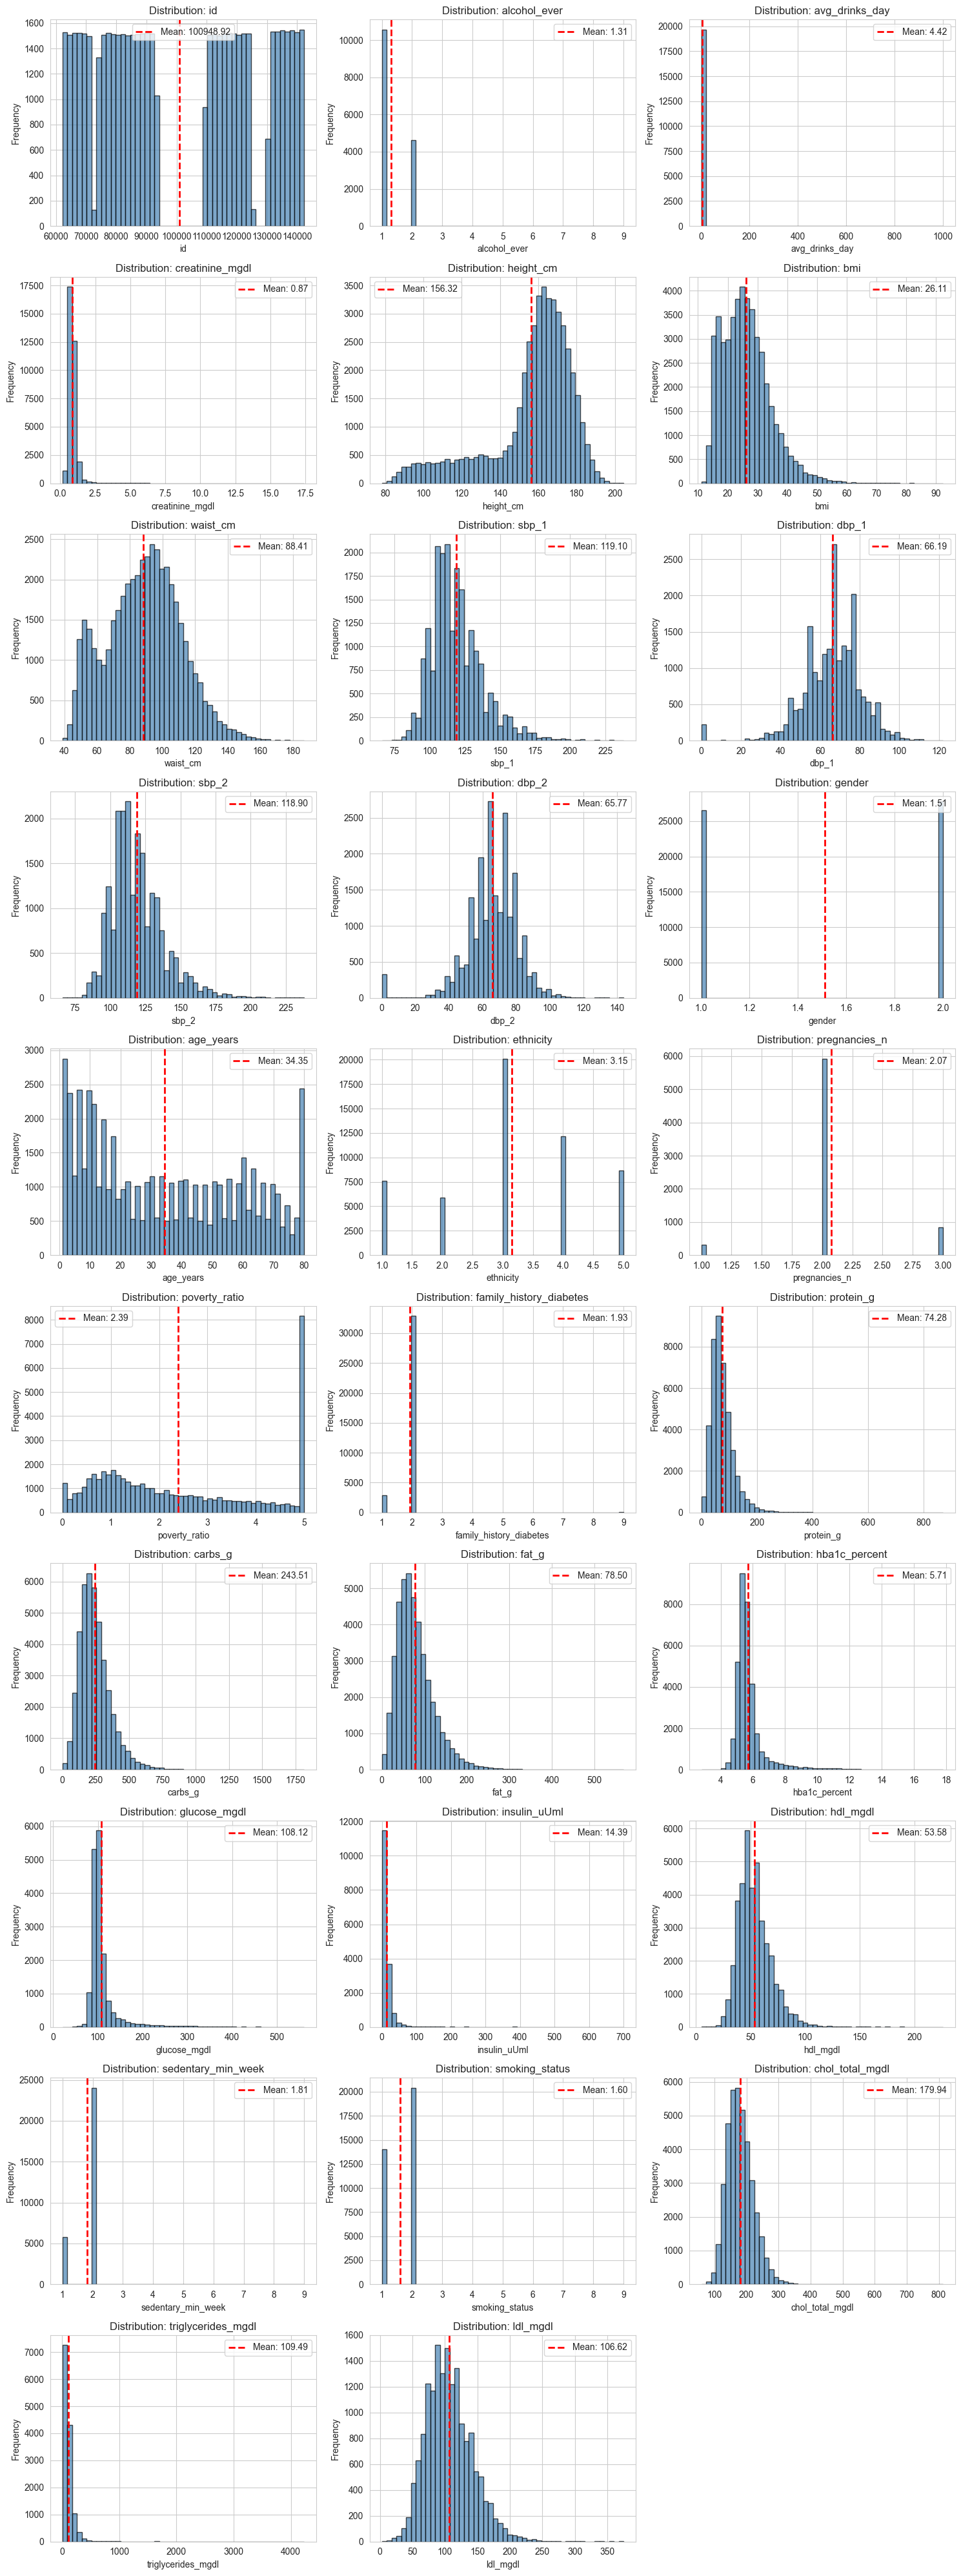

In [55]:
# Visualize distributions of all numeric variables using histograms
print("\nDistributions of Numeric Variables:")

n_cols = len(numeric_cols)
n_rows = (n_cols + 2) // 3

fig, axes = plt.subplots(n_rows, 3, figsize=(15, 4*n_rows))
axes = axes.flatten()

# Create histogram for each numeric variable
for idx, col in enumerate(numeric_cols):
    axes[idx].hist(df[col].dropna(), bins=50, color='steelblue', edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'Distribution: {col}')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')
    # Add mean line
    axes[idx].axvline(df[col].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df[col].mean():.2f}')
    axes[idx].legend()

# Hide empty subplots
for idx in range(n_cols, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

## 7. Outlier Detection

OUTLIER DETECTION (IQR Method)

Outliers detected (IQR * 1.5):


,count,percent,lower_bound,upper_bound
ethnicity,7602.0,13.979404,1.50000,5.50000
sedentary_min_week,5798.0,10.662008,2.00000,2.00000
height_cm,4833.0,8.887459,119.70000,202.10000
hba1c_percent,3253.0,5.981979,4.30000,6.70000
family_history_diabetes,2948.0,5.421111,2.00000,2.00000
glucose_mgdl,1604.0,2.949614,69.00000,133.00000
protein_g,1510.0,2.776756,-21.09625,160.73375
fat_g,1363.0,2.506436,-31.10500,178.29500
carbs_g,1302.0,2.394263,-47.08500,509.67500
insulin_uUml,1162.0,2.136815,-8.47000,30.81000


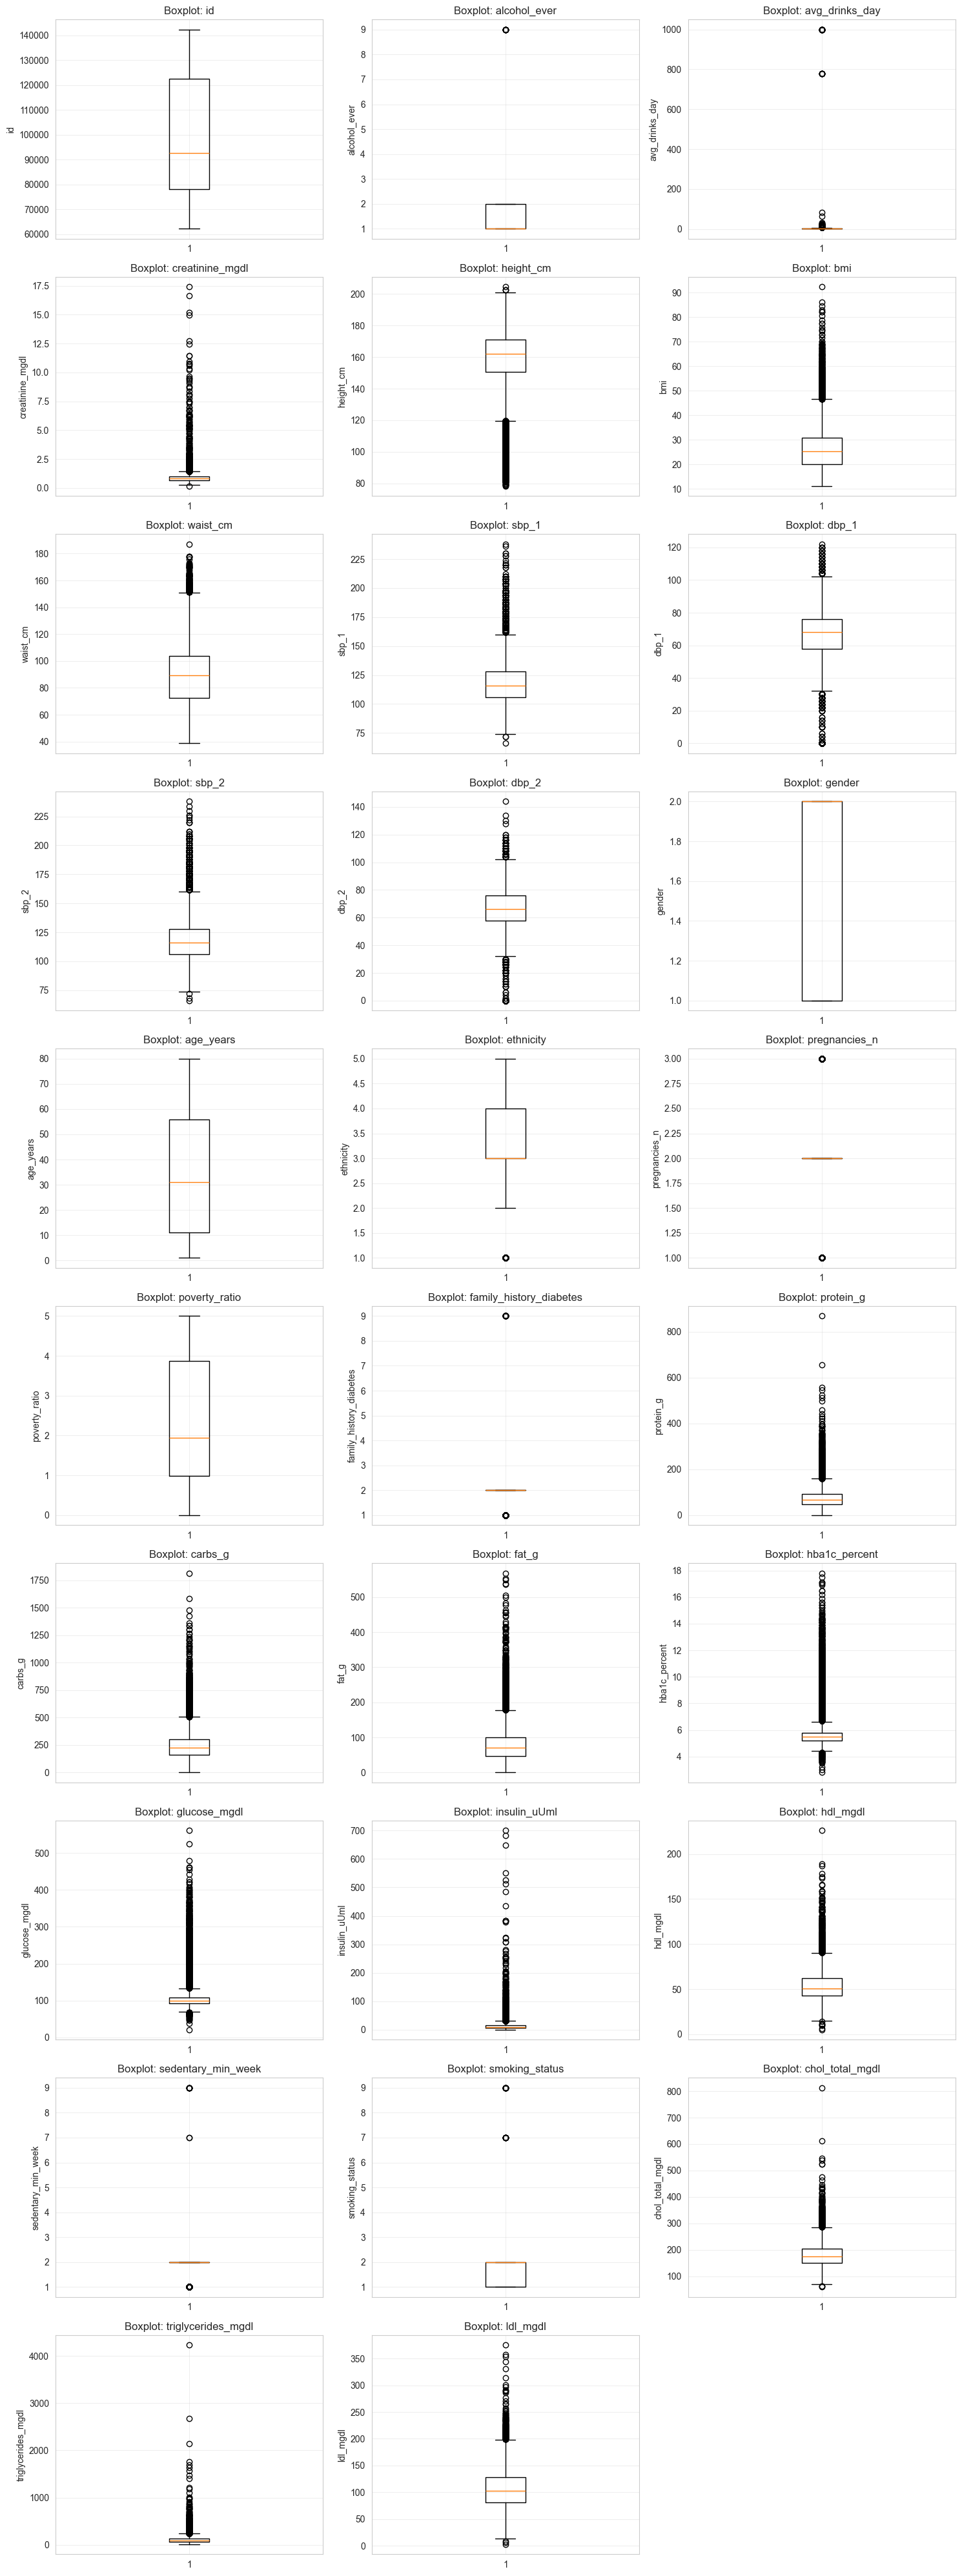

In [56]:
# Detect outliers using the Interquartile Range (IQR) method
print("=" * 80)
print("OUTLIER DETECTION (IQR Method)")
print("=" * 80)

outliers_summary = {}

# Calculate IQR bounds for each numeric variable
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    # Define outlier bounds (1.5 * IQR is standard)
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outliers_summary[col] = {
        'count': len(outliers),
        'percent': (len(outliers) / len(df)) * 100,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound
    }

outliers_df = pd.DataFrame(outliers_summary).T.sort_values('count', ascending=False)
print("\nOutliers detected (IQR * 1.5):")
display(outliers_df[outliers_df['count'] > 0])

# Visualize outliers using boxplots
fig, axes = plt.subplots(n_rows, 3, figsize=(15, 4*n_rows))
axes = axes.flatten()

for idx, col in enumerate(numeric_cols):
    axes[idx].boxplot(df[col].dropna())
    axes[idx].set_title(f'Boxplot: {col}')
    axes[idx].set_ylabel(col)
    axes[idx].grid(True, alpha=0.3)

# Hide empty subplots
for idx in range(n_cols, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

## 8. Correlation Analysis

CORRELATION ANALYSIS

Correlation with target variable (Diabetes):
hdl_mgdl                   0.122197
ldl_mgdl                   0.111779
carbs_g                    0.068844
smoking_status             0.063429
chol_total_mgdl            0.038743
poverty_ratio              0.016779
gender                     0.015108
ethnicity                  0.002495
avg_drinks_day            -0.001622
fat_g                     -0.002005
protein_g                 -0.006043
pregnancies_n             -0.009644
id                        -0.026106
sedentary_min_week        -0.042786
alcohol_ever              -0.046738
dbp_2                     -0.047147
dbp_1                     -0.050241
height_cm                 -0.135270
triglycerides_mgdl        -0.140432
creatinine_mgdl           -0.152328
insulin_uUml              -0.186488
sbp_2                     -0.225264
sbp_1                     -0.227042
bmi                       -0.251114
waist_cm                  -0.292359
age_years                 -0.3456

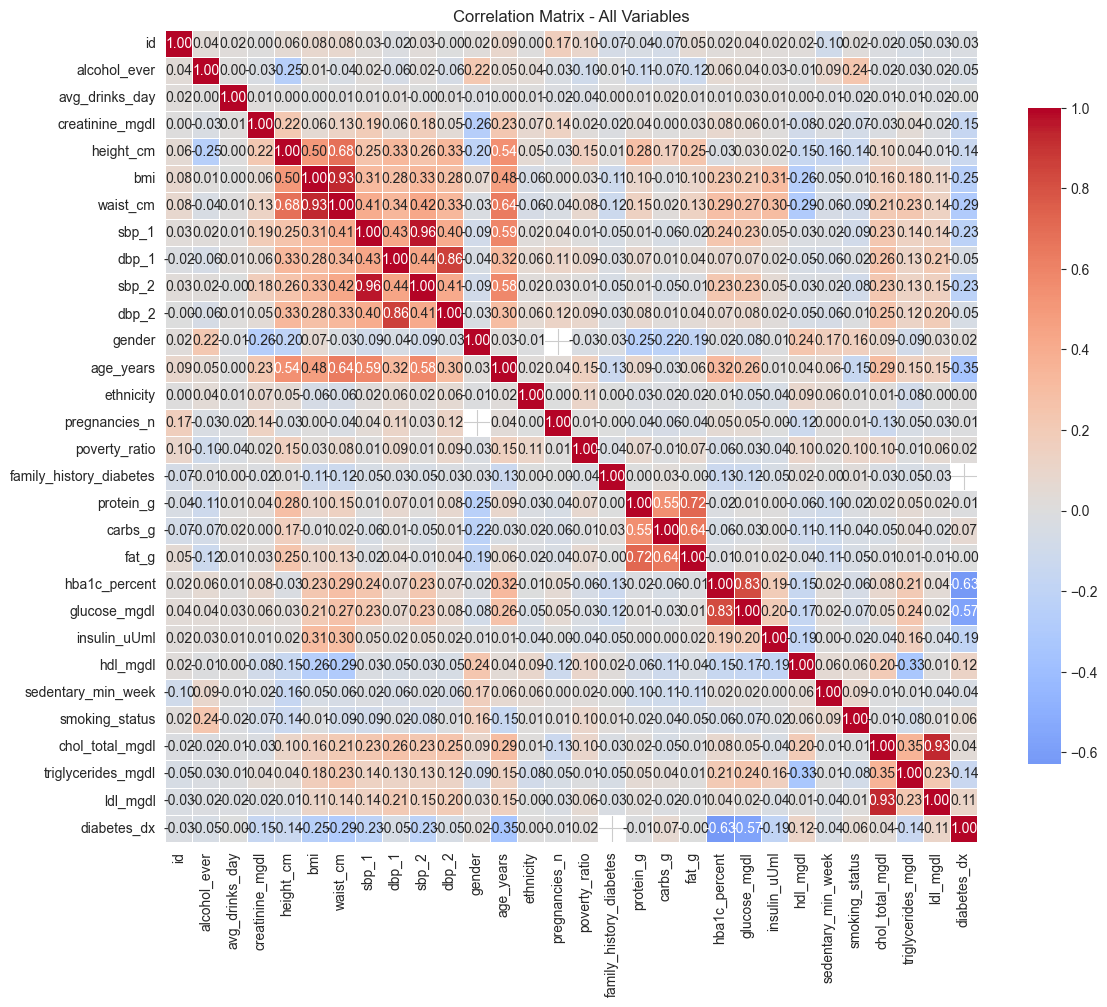

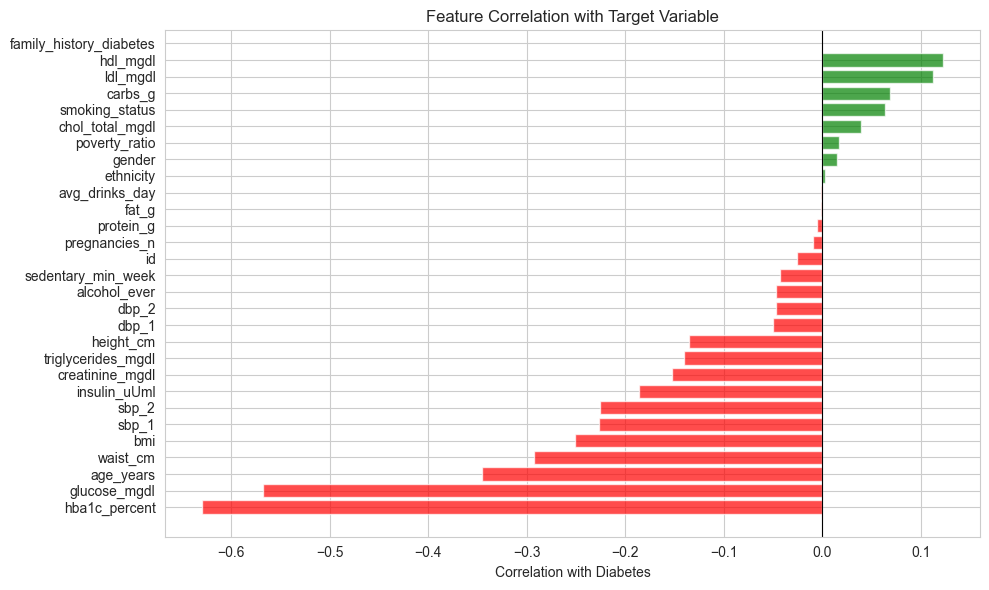

In [57]:
# Analyze correlations between variables and with target
print("=" * 80)
print("CORRELATION ANALYSIS")
print("=" * 80)

# Calculate correlation matrix
correlation_matrix = df[numeric_cols + [target_col]].corr()

# Display correlations with target variable
print("\nCorrelation with target variable (Diabetes):")
target_corr = correlation_matrix[target_col].drop(target_col).sort_values(ascending=False)
print(target_corr)

# Visualize full correlation matrix as heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            fmt='.2f', square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix - All Variables')
plt.tight_layout()
plt.show()

# Visualize only correlations with target variable
plt.figure(figsize=(10, 6))
target_corr_sorted = target_corr.sort_values()
colors = ['red' if x < 0 else 'green' for x in target_corr_sorted.values]
plt.barh(range(len(target_corr_sorted)), target_corr_sorted.values, color=colors, alpha=0.7)
plt.yticks(range(len(target_corr_sorted)), target_corr_sorted.index)
plt.xlabel('Correlation with Diabetes')
plt.title('Feature Correlation with Target Variable')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.tight_layout()
plt.show()

## 9. Analysis by Class (Diabetes vs. Non-Diabetes)

COMPARISON BETWEEN DIABETES CLASSES

Descriptive statistics by class:


diabetes_dx               1.0            2.0
id       count    4827.000000   49553.000000
         mean   103089.515641  100740.399794
         std     25275.524405   25613.074394
         min     62211.000000   62161.000000
         25%     79928.000000   78048.000000
...                       ...            ...
ldl_mgdl min         3.000000       9.000000
         25%        69.000000      83.000000
         50%        90.000000     105.000000
         75%       117.250000     129.000000
         max       354.000000     375.000000

[232 rows x 2 columns]


Comparison of means by class:


,id,alcohol_ever,avg_drinks_day,creatinine_mgdl,height_cm,bmi,waist_cm,sbp_1,dbp_1,sbp_2,...,fat_g,hba1c_percent,glucose_mgdl,insulin_uUml,hdl_mgdl,sedentary_min_week,smoking_status,chol_total_mgdl,triglycerides_mgdl,ldl_mgdl
diabetes_dx,,,,,,,,,,,,,,,,,,,,,
1.0,103089.515641,1.371945,4.604651,1.053861,165.962991,32.484270,109.555812,131.800887,68.443568,131.390810,...,78.782212,7.496871,160.295412,25.139976,48.246592,1.856412,1.514364,175.308423,145.821319,95.944000
2.0,100740.399794,1.301329,4.393444,0.845963,155.334643,25.469254,86.324296,117.720910,65.946758,117.522917,...,78.468623,5.459171,100.690692,12.877513,54.215269,1.802112,1.612979,180.494144,104.388999,108.098147


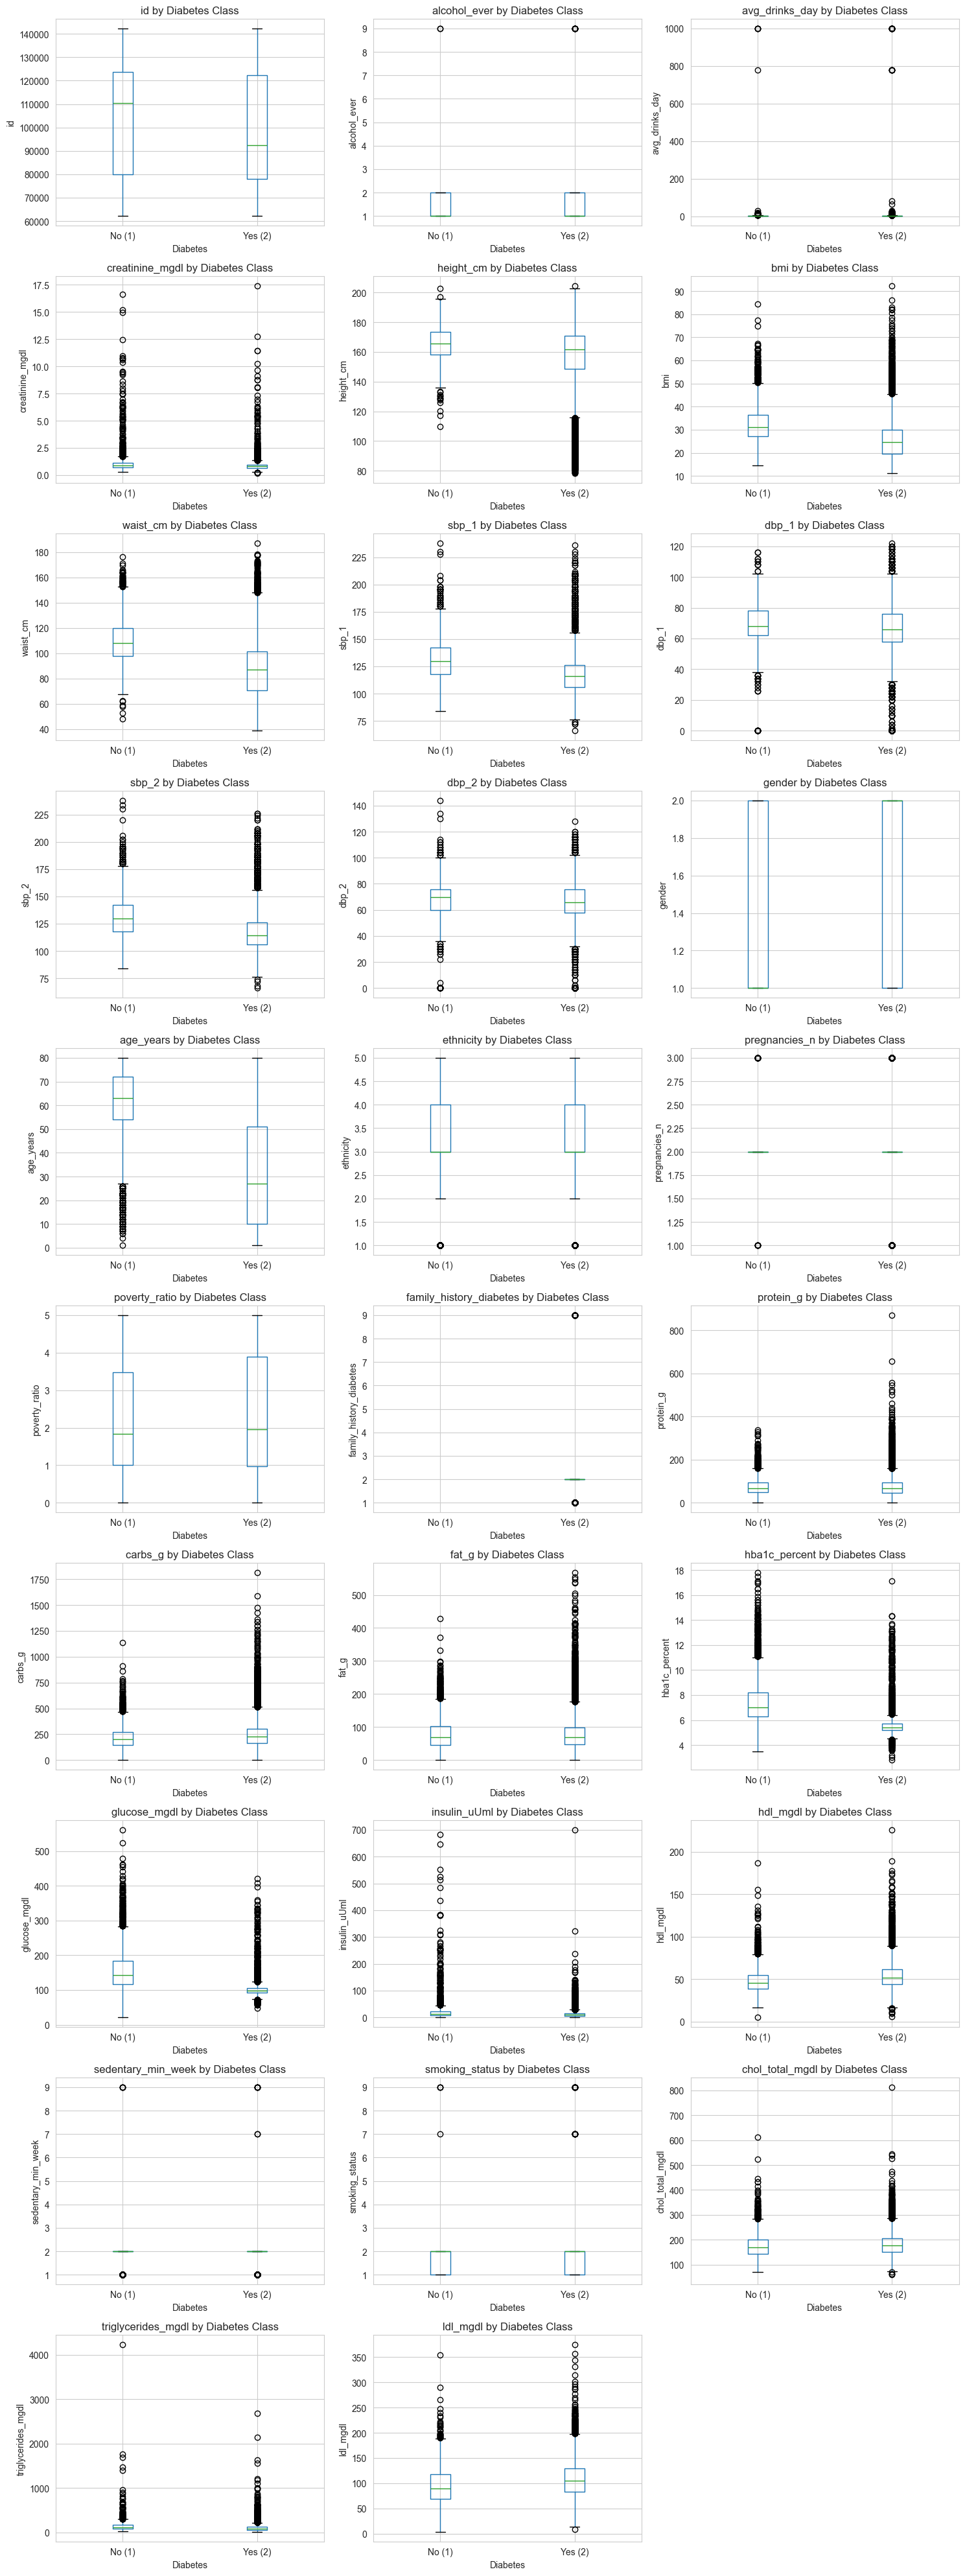

In [58]:
# Compare statistics between diabetes classes
print("=" * 80)
print("COMPARISON BETWEEN DIABETES CLASSES")
print("=" * 80)

# Display descriptive statistics grouped by class
print("\nDescriptive statistics by class:")
grouped_stats = df.groupby(target_col)[numeric_cols].describe().T
display(grouped_stats)

# Compare mean values between groups
print("\nComparison of means by class:")
comparison = df.groupby(target_col)[numeric_cols].mean()
display(comparison)

# Visualize differences using boxplots by class
fig, axes = plt.subplots(n_rows, 3, figsize=(15, 4*n_rows))
axes = axes.flatten()

for idx, col in enumerate(numeric_cols):
    df.boxplot(column=col, by=target_col, ax=axes[idx])
    axes[idx].set_title(f'{col} by Diabetes Class')
    axes[idx].set_xlabel('Diabetes')
    axes[idx].set_ylabel(col)
    plt.sca(axes[idx])
    plt.xticks([1, 2], ['No (1)', 'Yes (2)'])

# Remove the default title
plt.suptitle('')
# Hide empty subplots
for idx in range(n_cols, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

## 10. Statistical Tests (Group Differences)

In [59]:
# Perform t-tests to identify significant differences between groups
print("=" * 80)
print("STUDENT'S T-TEST - Difference Between Groups")
print("=" * 80)

# Separate data by class
group_1 = df[df[target_col] == 1][numeric_cols]
group_2 = df[df[target_col] == 2][numeric_cols]

# Perform t-test for each variable
print("\nStudent's t-test (H0: means are equal):")
t_test_results = {}

for col in numeric_cols:
    t_stat, p_value = stats.ttest_ind(group_1[col].dropna(), group_2[col].dropna())
    t_test_results[col] = {'t_statistic': t_stat, 'p_value': p_value}

t_test_df = pd.DataFrame(t_test_results).T.sort_values('p_value')
t_test_df['Significant (α=0.05)'] = t_test_df['p_value'] < 0.05

print("\nT-test results (sorted by p-value):")
display(t_test_df)

STUDENT'S T-TEST - Difference Between Groups

Student's t-test (H0: means are equal):

T-test results (sorted by p-value):


,t_statistic,p_value,Significant (α=0.05)
waist_cm,64.872430,0.000000e+00,True
bmi,56.281263,0.000000e+00,True
age_years,85.903718,0.000000e+00,True
hba1c_percent,150.613359,0.000000e+00,True
glucose_mgdl,90.273161,0.000000e+00,True
sbp_2,33.664143,4.470332e-242,True
sbp_1,33.508385,9.275949e-240,True
height_cm,29.645170,2.256262e-191,True
creatinine_mgdl,28.294370,4.422004e-174,True
insulin_uUml,24.447520,1.045384e-129,True


## 11. Categorical Variables Analysis

In [60]:
# Analyze categorical variables if any exist
print("=" * 80)
print("CATEGORICAL VARIABLES ANALYSIS")
print("=" * 80)

# Identify categorical columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

if categorical_cols:
    print(f"\nCategorical variables found: {len(categorical_cols)}")
    print(f"Columns: {categorical_cols}\n")

    # Display value counts for each categorical variable
    for col in categorical_cols:
        print(f"\n{col}:")
        print(f"Unique values: {df[col].nunique()}")
        print(df[col].value_counts())
else:
    print("\nNo categorical variables found")

CATEGORICAL VARIABLES ANALYSIS

Categorical variables found: 1
Columns: ['cycle']


cycle:
Unique values: 5
cycle
2017-2020    14694
2021-2022    11452
2013-2014     9578
2015-2016     9424
2011-2012     9232
Name: count, dtype: int64


## 12. EDA Summary and Recommendations

In [ ]:
# Generate comprehensive EDA summary report
print("=" * 80)
print("EDA SUMMARY")
print("=" * 80)

# Create summary report with key findings
summary_report = f"""
DIMENSIONS AND STRUCTURE:
  • Total records: {len(df):,}
  • Total variables: {df.shape[1]}
  • Numeric variables: {len(numeric_cols)}
  • Categorical variables: {len(categorical_cols)}

MISSING DATA:
  • Total percentage of missing data: {(df.isnull().sum().sum() / (len(df) * df.shape[1])) * 100:.2f}%
  • Columns with missing values: {missing_data.sum()}

TARGET VARIABLE (Diabetes):
  • Class 1 (No Diabetes): {class_dist.get(1, 0):,} records ({(class_dist.get(1, 0)/len(df)*100):.1f}%)
  • Class 2 (Yes Diabetes): {class_dist.get(2, 0):,} records ({(class_dist.get(2, 0)/len(df)*100):.1f}%)
  • Imbalance ratio: {imbalance_ratio:.2f}:1

OUTLIERS:
  • Variables with outliers: {sum(1 for x in outliers_df['count'] if x > 0)}
  • Total outliers detected: {outliers_df['count'].sum():.0f}

CORRELATION:
  • Top 5 variables most correlated with Diabetes:
{target_corr.head(5).to_string()}
"""

print(summary_report)

EDA SUMMARY

DIMENSIONS AND STRUCTURE:
  • Total records: 54,380
  • Total variables: 31
  • Numeric variables: 29
  • Categorical variables: 1

MISSING DATA:
  • Total percentage of missing data: 36.20%
  • Columns with missing values: 666610

TARGET VARIABLE (Diabetes):
  • Class 1 (No Diabetes): 4,827 records (8.9%)
  • Class 2 (Yes Diabetes): 49,553 records (91.1%)
  • Imbalance ratio: 10.27:1

OUTLIERS:
  • Variables with outliers: 25
  • Total outliers detected: 40133

CORRELATION:
  • Top 5 variables most correlated with Diabetes:
hdl_mgdl           0.122197
ldl_mgdl           0.111779
carbs_g            0.068844
smoking_status     0.063429
chol_total_mgdl    0.038743


✓ Report saved to 'eda_summary_report.txt'
